In [1]:
# RNN
# 潜变量自回归
# P(ht|h(t-1),x(t-1))
# P(xt|ht,x(t-1))
# ht=f(Whh*h(t-1)+Whx*x(t-1)+bh)
# ot=Woh*ht+bo
# Whh 存时序信息

# 困惑度(perplexity)
# 分类问题 平均交叉熵
# n长度就是n分类 平均交叉熵
# NLP 使用 exp(Pi) 衡量 (放大/历史原因/意义 平均候选词)
# 1 完美 inf 最差情况
# 困惑度 k k个词都有可能

In [2]:
# 梯度剪裁
# T个时间步上的梯度
# 反向传播产生O(T)的矩阵乘法链,导致数值不稳定
# 梯度裁剪防止梯度爆炸
# 如果梯度大学超过theta 拖回theta
# g=min(1,theta/||g||)*g

In [3]:
# one to one MLP
# one to many 文本生成
# many to one 文本分类
# many to many 问答，机器翻译
# many to many Tag生成

In [4]:
# RNN 输出取决于当下输入和前一时间的隐变量
# 语言模型，根据当前预测下一时刻词
# 困惑度(平均下来多少候选词)

In [5]:
%matplotlib inline
import math 
import torch 
from torch import nn 
from torch.nn import functional as F 
from d2l import torch as d2l 

In [6]:
batch_size=32
num_step=35
train_iter,vocab=d2l.load_data_time_machine(
    batch_size,num_step)

In [7]:
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [8]:
X=torch.arange(10).reshape((2,5))
F.one_hot(X.T,28).shape
# 转置后第一个维度是时间

torch.Size([5, 2, 28])

In [9]:
def get_params(vocab_size,num_hiddens,device):
    num_input=num_output=vocab_size
    # 输入one-hot 输出n元分类
    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01

    W_xh=normal((num_input,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=torch.zeros(num_hiddens,device=device)
    W_hq=normal((num_hiddens,num_output))
    b_q=torch.zeros(num_output,device=device)
    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [10]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [11]:
def rnn(inputs,state,params):
    W_xh,W_hh,b_h,W_hq,b_q=params
    H,=state
    outputs=[]
    # 时间转置的原因
    for X in inputs:
        H=torch.tanh(
            X@W_xh+H@W_hh+b_h
        )
        Y=H@W_hq+b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)
    

In [12]:
class RNNModelScratch:
    """从零开始实现RNN"""
    def __init__(self,vocab_size,num_hiddens,device,
            get_params,init_state,forward_fn) -> None:
        self.vocab_size,self.num_hiddens=vocab_size,num_hiddens
        self.params=get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn=init_state,forward_fn
        
    # X (batch_size,time_step)
    def __call__(self,X,state):
        X=F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [13]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape
# 10 个词 28 分类

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [14]:
def predict_ch8(prefix,num_preds,net,vocab,device):
    """一个字符串预测"""
    state=net.begin_state(1,device=device)
    print(state[0].shape)
    outputs=[vocab[prefix[0]]]
    get_inputs=lambda : torch.tensor([outputs[-1]],device=device).reshape(1,1)
    for y in prefix[1:]:
        _,state=net(get_inputs(),state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y,state=net(get_inputs(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return "".join([vocab.idx_to_token[i] for i in outputs]) 

In [15]:
X.shape

torch.Size([2, 5])

In [16]:
# 未训练
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

torch.Size([1, 512])


'time traveller y<unk>qezvgdpw'

In [17]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    # 注意是所有梯度构成一个大向量
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


In [18]:
def train_epoch_ch8(net,train_iter,loss,updater,
                    device,use_random_iter):
    """训练一个epoch"""
    state,timer=None,d2l.Timer()
    metric=d2l.Accumulator(2)
    for X,Y in train_iter:
        if state is None or use_random_iter:
            state=net.begin_state(batch_size=X.shape[0],device=device)
        else: 
             if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
             else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


In [19]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        def updater(batch_size): return d2l.sgd(net.params, lr, batch_size)

    def predict(prefix): return predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


困惑度 1.2, 92758.6 标记/秒 cuda:0
torch.Size([1, 512])
time traveller proceeded anyreal body must having the time trave
torch.Size([1, 512])
travelleryou can show black is white by argument said filby


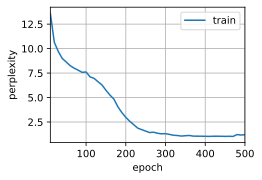

In [20]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())
# 把书记住了

困惑度 1.2, 83968.0 标记/秒 cuda:0
torch.Size([1, 512])
time travellerit s against reason said filbywhat is he ard bensb
torch.Size([1, 512])
traveller held in his hand was a glitteringmetallic framewo


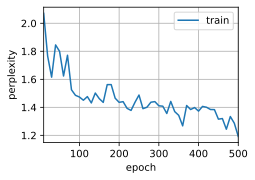

In [21]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),use_random_iter=True)
# 随机性更强 没有完全记住

In [22]:
import torch 
from torch import nn 
from torch.nn import functional as F 
from d2l import torch as d2l

In [23]:
batch_size,num_step=32,35
train_iter,vocab=d2l.load_data_time_machine(
    batch_size,num_step
)

In [24]:
num_hiddens=256
rnn_layer=nn.RNN(len(vocab),num_hiddens)

In [25]:
state=torch.zeros((1,batch_size,num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [26]:
X=torch.rand(size=(num_step,batch_size,len(vocab)))
Y,state_new=rnn_layer(X,state)
Y.shape,state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [27]:
len(vocab)

28

In [28]:
# Pytorch RNN 不包括输出层
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self,rnn_layer,vocab_size,**kwargs) -> None:
        super(RNNModel,self).__init__(**kwargs)
        self.rnn=rnn_layer
        self.vocab_size=vocab_size
        self.num_hiddens=self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                     batch_size, self.num_hiddens),
                                    device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                     batch_size, self.num_hiddens),
                                    device=device))


In [29]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)


'time travellerqbqqbqqbqq'

perplexity 1.3, 298553.1 tokens/sec on cuda:0
time traveller came abare are aimed and unalterable thingscor th
travellery moves along the fourd ard matherisacurecullidif 


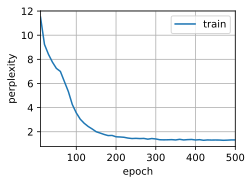

In [30]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)
# 多次小矩阵乘法 开销大于 大矩阵乘法